In [1]:
%matplotlib inline
from pathlib import Path
import sys

PROJ_DIR = Path.cwd().parent
sys.path.append(str(PROJ_DIR))
assert PROJ_DIR.is_dir()

import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os.path as osp
import json

sns.set(style="whitegrid", font_scale=1)
sns.set_palette(sns.color_palette('bright'))
sns.set_palette([(0.0, 0.24705882352941178, 1.0),
                 (0.011764705882352941, 0.9294117647058824, 0.22745098039215686),
                 (0.9098039215686274, 0.0, 0.043137254901960784),
                 (0.5411764705882353, 0.16862745098039217, 0.8862745098039215),
                 (1.0, 0.7686274509803922, 0.0),
                 (0.0, 0.8431372549019608, 1.0)])

print(PROJ_DIR)

SMOOTHFACTOR = 0.9
SMOOTHFACTOR2 = 20
SMOOTHFACTOR3 = 20
DIV_LINE_WIDTH = 50
fontsize = 10
paper = True
env_name_dict = {
    'quadrotor': 'Quadrotor Circle Tracking',
    'safetygym-car': 'CarGoal',
    'safetygym-point': 'PointGoal',
    'cartpole-move': 'Cartpole-Move',
    'cartpole-upright': 'Cartpole-Upright',
}
tag_name_dict = {
    'episode_return': 'Episode return',
    'episode_constraint_violation': 'Episode constraint violation',
    'total_violation': '# of unsafe trajectories'
}

ylim_dict = {
    'episode_return': {
        'quadrotor': [-4, -1],
        'safetygym-car': [-5, 33],
        'safetygym-point': [-5, 30],
        'cartpole-move': [-10, 1000]
    },
    'episode_constraint_violation': {
        'safetygym-point': [-2, 30],
        'safetygym-car': [-2, 50],
        'quadrotor': [-5, 400],
        'cartpole-move': [-10, 1000]
    },
    'total_violation': {
        'safetygym-car': [-2, 50],
    }
}

txt_store_alg_list = ['Raw RMBPO', 'only w/ shield', 'only w/ uncertainty', 'w/ uncertainty & shield']

def is_eval_metric(metric: str):
    return metric.startswith('episode')

csv_col2tag = {
    'total violations': 'total_violation',
    'eval return mean': 'episode_return',
    'eval violation mean': 'episode_constraint_violation'
}
tag2csv_col = dict(zip(csv_col2tag.values(), csv_col2tag.keys()))
print(tag2csv_col)

/home/moon/Desktop/Safe_MBRL
{'total_violation': 'total violations', 'episode_return': 'eval return mean', 'episode_constraint_violation': 'eval violation mean'}


/home/moon/Desktop/Safe_MBRL/logs/safetygym-point/08-24-22_09.08.59_neither/eval.csv
/home/moon/Desktop/Safe_MBRL/logs/safetygym-point/08-23-22_16.06.40_r0_15_shield_only/eval.csv
/home/moon/Desktop/Safe_MBRL/logs/safetygym-point/08-23-22_20.48.34_r0_15_uncertainty_only/eval.csv
/home/moon/Desktop/Safe_MBRL/logs/safetygym-point/08-23-22_10.59.01_r0_15_both/eval.csv


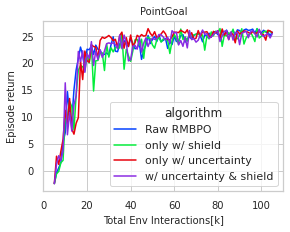

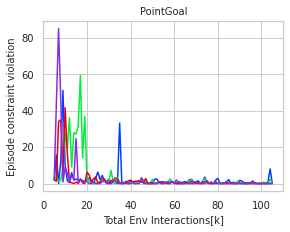

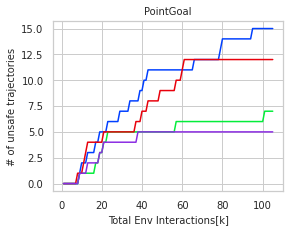

In [2]:
# -------------------------------------------------- #
# You need to add the corresponding results dir of each
# algorithm into its dict here.
RESULTS_DIR = {
    'safetygym-car': {
        'RMBPO': [
            '07-26-22_00.06.37_gsxc',
        ],
        'RMBPO-shield': [
            '07-27-22_00.02.30_rnwo',
        ]
    },

    'safetygym-point': {
        'Raw RMBPO': [
            '08-24-22_09.08.59_neither'
        ],
        'only w/ shield': [
            '08-23-22_16.06.40_r0_15_shield_only'
        ],
        'only w/ uncertainty': [
            '08-23-22_20.48.34_r0_15_uncertainty_only'
        ],
        'w/ uncertainty & shield': [
            '08-23-22_10.59.01_r0_15_both'
        ]
    },
    
    'quadrotor': {
        'Raw RMBPO': [
            '07-04-22_13.39.40_model-sample'
        ],
        'only w/ shield': [
            '07-05-22_18.16.43_shield'
        ],
        'only w/ uncertainty': [
            '07-07-22_15.09.38_distr_good'
        ],
        'w/ uncertainty & shield': [
            '07-09-22_00.33.26_both'
        ]
    }
}

# -------------------------------------------------- #

def help_func():
    tag2plot = ['episode_return', 'episode_constraint_violation', 'total_violation']
    alg_list = ['Raw RMBPO', 'only w/ shield', 'only w/ uncertainty', 'w/ uncertainty & shield']
    result_dir = PROJ_DIR / 'logs'
    return tag2plot, alg_list, result_dir

def plot_eval_results_of_all_alg_n_runs(task):
    tag2plot, alg_list, result_dir = help_func()
    result_dir = result_dir / task
    assert result_dir.is_dir()

    train_in_one_run_of_one_alg = {}
    train_list = []

    eval_in_one_run_of_one_alg = {}
    eval_list = []

    for alg in alg_list:
        for run_idx, run_dir in enumerate(RESULTS_DIR[task][alg]):            
            if alg in txt_store_alg_list:
                # read files
                eval_file = result_dir / run_dir / 'eval.csv'
                train_file = result_dir / run_dir / 'episodes.csv'
                cfg = result_dir / run_dir / 'config.json'
                assert eval_file.is_file()
                assert train_file.is_file()
                assert cfg.is_file()
                df_train = pd.read_csv(train_file)
                df_eval = pd.read_csv(eval_file)
                print(eval_file)

                # preprocess, add necessary columns
                with open(cfg, 'r') as f:
                    cfg_dict = json.load(f)
                steps_per_epoch = cfg_dict['alg_cfg']['steps_per_epoch']
                epochs = cfg_dict['epochs']
                buffer_min = cfg_dict['alg_cfg']['buffer_min']
                if cfg_dict['alg_cfg']['alive_bonus'] > 0:
                    df_eval.loc[:, 'eval return mean'] += cfg_dict['alg_cfg']['alive_bonus'] * df_eval.loc[:, 'eval length mean']

                df_eval.insert(
                    len(df_eval.columns),
                    'steps sampled',
                    (buffer_min + np.arange(0, steps_per_epoch*epochs + 1, steps_per_epoch)) / 1e3
                ) 
                df_eval.insert(len(df_eval.columns), 'algorithm', alg)
                df_eval.insert(len(df_eval.columns), 'run_idx', run_idx)
                
                select_row = df_train.loc[:, 'steps sampled'] % steps_per_epoch == 0
                df_train = df_train[select_row]
                df_train.loc[:, 'steps sampled'] /= 1e3
                df_train.insert(len(df_train.columns), 'algorithm', alg)
                df_train.insert(len(df_train.columns), 'run_idx', run_idx)

                # add insterested columns (tag)
                for tag in tag2plot:
                    if is_eval_metric(tag):
                        df_eval.insert(len(df_eval.columns), tag, df_eval.loc[:, tag2csv_col[tag]])
                    else:
                        df_train.insert(
                            len(df_train.columns), tag, 
                            df_train.loc[:, tag2csv_col[tag]]
                        )
                train_list.append(df_train)
                eval_list.append(df_eval)

                # print(df_train[:10])

    total_train_df = train_list[0].append(train_list[1:], ignore_index=True) if len(train_list) > 1 else \
                     train_list[0]
    total_eval_df = eval_list[0].append(eval_list[1:], ignore_index=True) if len(eval_list) > 1 else \
                    eval_list[0]

    for i, tag in enumerate(tag2plot):
        figsize = (4, 3)
        plt.figure(figsize=figsize)  # figsize=figsize
        ax1 = plt.axes()  # f1.add_axes(axes_size)
        sns.lineplot(
            x="steps sampled", 
            y=tag, 
            hue="algorithm",
            data=total_eval_df if is_eval_metric(tag) else total_train_df,
        )

        ax1.set_ylabel(tag_name_dict[tag], fontsize=fontsize)
        ax1.set_xlabel("Total Env Interactions[k]", fontsize=fontsize)
        handles, labels = ax1.get_legend_handles_labels()
        if i != 0:
            ax1.get_legend().remove()

        plt.yticks(fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.tight_layout(pad=0.5)
        plt.title(env_name_dict[task], fontsize=fontsize)

        plt.show()


plot_eval_results_of_all_alg_n_runs('safetygym-point')
# 


In [15]:
is_eval_metric('episode_return')

True